In [5]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns
from scipy.special import rel_entr
import scipy.stats as stats
from scipy.special import kl_div
from scipy.ndimage import gaussian_filter1d

In [2]:
martinez = xr.open_dataset('martinezOnsetDemise_ERA5.nc')
bombardi = xr.open_dataset('bombardiOnsetDemise_ERA5.nc')

In [3]:
diff = (martinez['demise_date'] - martinez['onset_date']).dt.days

In [25]:
def _calc_slope(x, y):
    '''wrapper that returns the slop from a linear regression fit of x and y'''
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.all(np.isnan(y)):
        return np.nan
    else:
        slope = stats.linregress(x[mask], y[mask])[0]  # extract slope only
    
        return slope

In [7]:
diff

<xarray.DataArray 'days' (latitude: 41, longitude: 121, year: 71)>
array([[[ 151.,  158.,  131., ...,  163.,   nan,   nan],
        [ 150.,  157.,  131., ...,  163.,   nan,   nan],
        [ 151.,  156.,  130., ...,  161.,   nan,   nan],
        ...,
        [  nan,  173.,  175., ...,  227.,  154.,   nan],
        [  nan,  173.,  182., ...,  248.,  167.,   nan],
        [  nan,  174.,  207., ...,  249.,   nan,   nan]],

       [[ 151.,  151.,  142., ...,  182.,   nan,   nan],
        [ 150.,  151.,  113., ...,  184.,   nan,   nan],
        [ 153.,  148.,   85., ...,  184.,   nan,   nan],
        ...,
        [  nan,   39.,  -69., ..., -209.,   nan,   nan],
        [  nan,   64.,  -70., ..., -224.,   nan,   nan],
        [  nan,   65., -202., ..., -205.,   nan,   nan]],

       [[ 143.,  150.,  129., ...,  116.,   nan,   nan],
        [ 151.,  150.,   98., ...,  138.,   nan,   nan],
        [ 150.,  150.,  101., ...,  138.,   nan,   nan],
        ...,
...
        ...,
        [  46.,  208.,   43., ...,  -91.,   nan,   nan],
        [ 185.,  326.,  133., ...,  173.,   nan,   nan],
        [ 155.,  208.,  306., ...,  342.,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [ 156.,  241.,  232., ...,  191.,   61.,   nan],
        [ 155.,  208.,  225., ...,  191.,   62.,   nan],
        [ 154.,  207.,  188., ...,  227.,  131.,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [ 155.,  180.,  199., ...,  192.,   84.,   nan],
        [ 154.,  180.,  217., ...,  203.,   60.,   nan],
        [ 154.,  179.,  217., ...,  203.,  188.,   nan]]])
Coordinates:
  * longitude  (longitude) float32 235.0 235.5 236.0 236.5 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
  * year       (year) datetime64[ns] 1950-01-01 1951-01-01 ... 2020-01-01

In [26]:
def linear_trend(obj):
    time_nums = xr.DataArray(obj['year'].values.astype(np.float),
                             dims='year',
                             coords={'year': obj['year']},
                             name='year_nums')
    
    trend = xr.apply_ufunc(_calc_slope, time_nums, obj,
                           vectorize=True,
                           input_core_dims=[['year'], ['year']],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')

    return trend

In [17]:
diff


<xarray.DataArray 'days' (latitude: 41, longitude: 121, year: 71)>
array([[[ 151.,  158.,  131., ...,  163.,   nan,   nan],
        [ 150.,  157.,  131., ...,  163.,   nan,   nan],
        [ 151.,  156.,  130., ...,  161.,   nan,   nan],
        ...,
        [  nan,  173.,  175., ...,  227.,  154.,   nan],
        [  nan,  173.,  182., ...,  248.,  167.,   nan],
        [  nan,  174.,  207., ...,  249.,   nan,   nan]],

       [[ 151.,  151.,  142., ...,  182.,   nan,   nan],
        [ 150.,  151.,  113., ...,  184.,   nan,   nan],
        [ 153.,  148.,   85., ...,  184.,   nan,   nan],
        ...,
        [  nan,   39.,  -69., ..., -209.,   nan,   nan],
        [  nan,   64.,  -70., ..., -224.,   nan,   nan],
        [  nan,   65., -202., ..., -205.,   nan,   nan]],

       [[ 143.,  150.,  129., ...,  116.,   nan,   nan],
        [ 151.,  150.,   98., ...,  138.,   nan,   nan],
        [ 150.,  150.,  101., ...,  138.,   nan,   nan],
        ...,
...
        ...,
        [  46.,  208.,   43., ...,  -91.,   nan,   nan],
        [ 185.,  326.,  133., ...,  173.,   nan,   nan],
        [ 155.,  208.,  306., ...,  342.,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [ 156.,  241.,  232., ...,  191.,   61.,   nan],
        [ 155.,  208.,  225., ...,  191.,   62.,   nan],
        [ 154.,  207.,  188., ...,  227.,  131.,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [ 155.,  180.,  199., ...,  192.,   84.,   nan],
        [ 154.,  180.,  217., ...,  203.,   60.,   nan],
        [ 154.,  179.,  217., ...,  203.,  188.,   nan]]])
Coordinates:
  * longitude  (longitude) float32 235.0 235.5 236.0 236.5 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
  * year       (year) datetime64[ns] 1950-01-01 1951-01-01 ... 2020-01-01

In [27]:
diff_trend = linear_trend(diff)

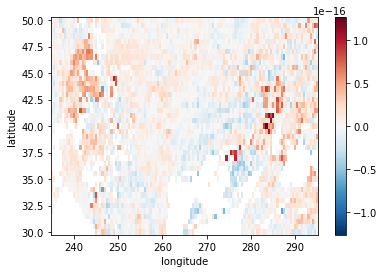

In [28]:
diff_trend.plot()

In [11]:
diff.isel(year=25).where(diff.isel(year=25) < 0, drop=True).longitude

<xarray.DataArray 'longitude' (longitude: 78)>
array([239. , 239.5, 240. , 240.5, 241. , 241.5, 242. , 242.5, 243. , 243.5,
       244. , 244.5, 245. , 245.5, 246. , 246.5, 247. , 247.5, 248. , 248.5,
       249. , 250. , 252.5, 260.5, 265.5, 266. , 266.5, 267. , 267.5, 268. ,
       268.5, 272. , 272.5, 273. , 273.5, 274. , 274.5, 275. , 275.5, 276. ,
       276.5, 277. , 277.5, 278. , 278.5, 279. , 279.5, 280. , 280.5, 281. ,
       281.5, 282. , 282.5, 283. , 283.5, 284. , 284.5, 285. , 285.5, 286. ,
       286.5, 287. , 287.5, 288. , 288.5, 289. , 289.5, 290. , 290.5, 291. ,
       291.5, 292. , 292.5, 293. , 293.5, 294. , 294.5, 295. ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 239.0 239.5 240.0 240.5 ... 294.0 294.5 295.0
    year       datetime64[ns] 1975-01-01

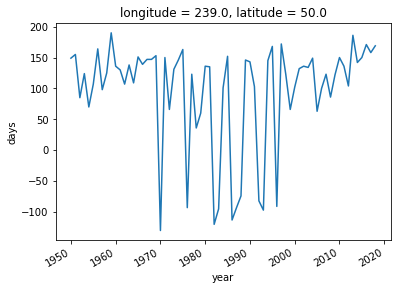

In [13]:
diff.sel(latitude=50, longitude=239).plot()

In [52]:
B_onset_trend = linear_trend(bombardi['demise_doy'])

In [53]:
M_onset_trend = linear_trend(martinez['demise_doy'])

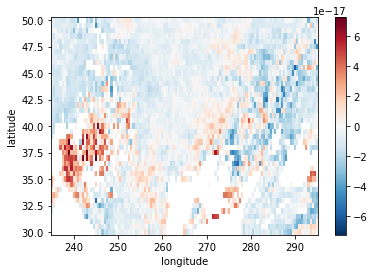

In [38]:
M_onset_trend.plot()


In [29]:
Bdiff = np.abs((bombardi['demise_date'] - bombardi['onset_date'])).dt.days

In [30]:
Bdiff_trend = linear_trend(Bdiff)

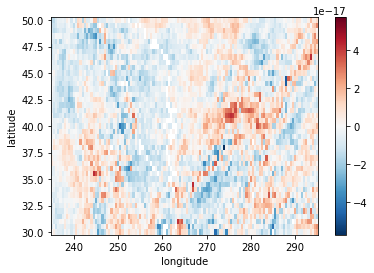

In [31]:
Bdiff_trend

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


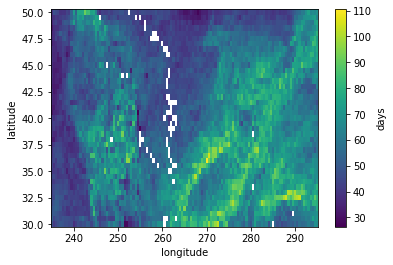

In [26]:
Bdiff.std(dim='year').plot()

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


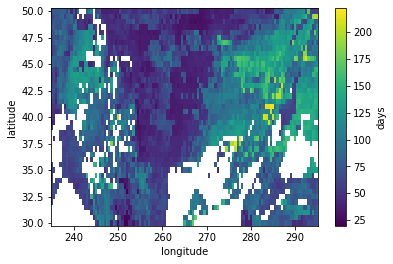

In [27]:
diff.std(dim='year').plot()

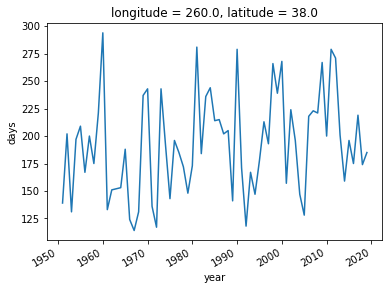

In [29]:
diff.sel(latitude=38,longitude=260).plot()

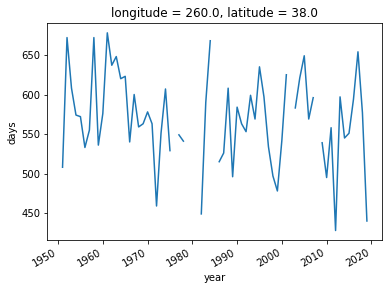

In [30]:
Bdiff.sel(latitude=38,longitude=260).plot()

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


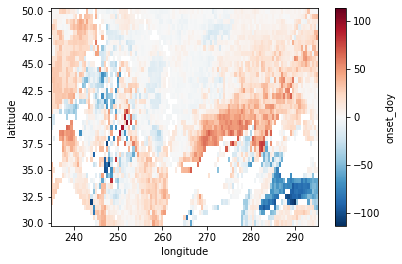

In [15]:
(martinez['onset_doy'].std(dim='year').squeeze() - bombardi['onset_doy'].std(dim='year').squeeze()).plot()

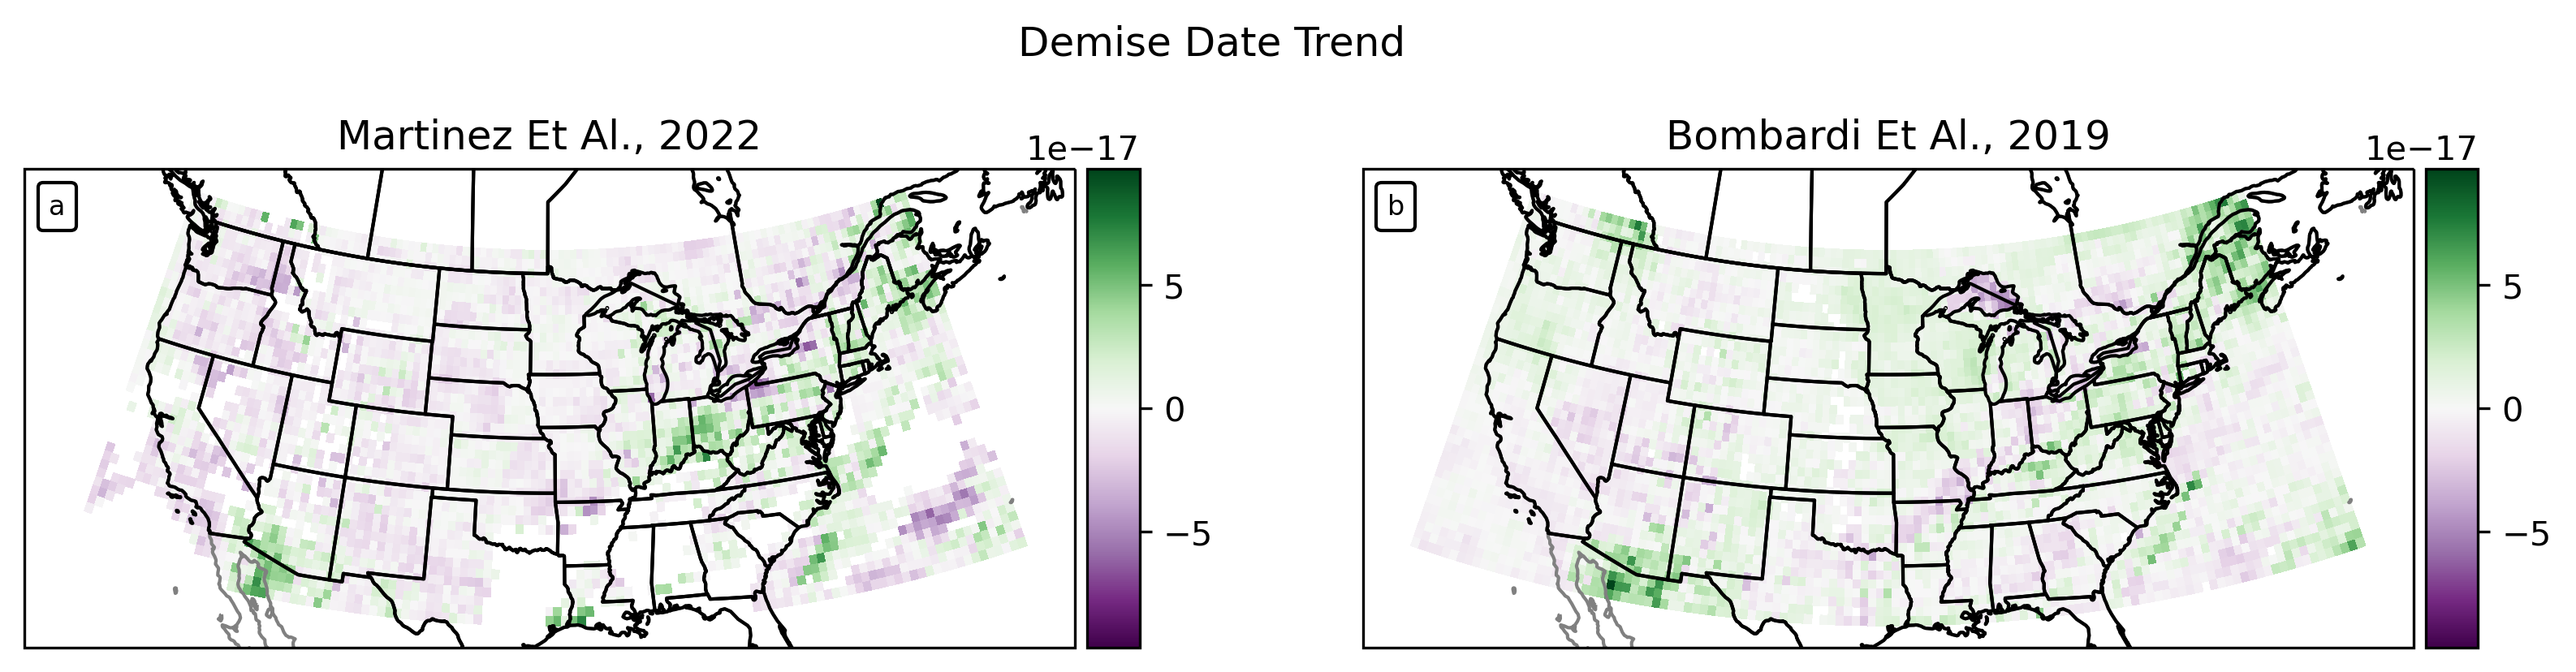

In [54]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r
fig, ax = plt.subplots(ncols=2, figsize = (13, 8), dpi = 300, subplot_kw={'projection': map_proj})


p = M_onset_trend.plot.pcolormesh(ax=ax[0],transform=ccrs.PlateCarree(), add_colorbar=False, cmap='PRGn')

B_onset_trend.plot.pcolormesh(ax=ax[1],transform=ccrs.PlateCarree(), add_colorbar=False, cmap='PRGn')

### Setting 1st plot parameters ###
ax[0].set_title('Martinez Et Al., 2022')
ax[0].coastlines(color='grey')
ax[0].add_feature(cartopy.feature.BORDERS, color='black')
ax[0].add_feature(cfeature.STATES, edgecolor='black')
#ax[0].set_xticks(np.arange(-180,181, 40))
#ax[0].set_yticks(np.arange(-90,91,15))
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[0].add_artist(at)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)
    
### Setting 2nd plot parameters ###
ax[1].set_title('Bombardi Et Al., 2019')
ax[1].coastlines(color='grey')
ax[1].add_feature(cartopy.feature.BORDERS, color='black')
ax[1].add_feature(cfeature.STATES, edgecolor='black')
#ax[1].set_xticks(np.arange(-180,181, 40))
#ax[1].set_yticks(np.arange(-90,91,15))
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
at = AnchoredText("b",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[1].add_artist(at)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)
fig.suptitle('Demise Date Trend', y=0.7)

plt.show()